## 10 시계열을 위한 딥러닝

10.1 다양한 종류의 시계열 작업 <br>
10.2 온도 예측 문제 <br>
10.3 순환 신경망 이해하기 <br>
10.4 순환 신경망의 고급 사용법 <br>
10.5 요약 <br>

### 10.1 다양한 종류의 시계열 작업
시계열(timeseries) 데이터는 일정한 간격으로 측정하여 얻은 모든 데이터를 말한다. 일반적인 시계열 관련 작업은 <b>예측</b>이다. 시계열로 할 수 있는 작업은 다양하다. <br>

- <b>분류</b>: 하나 이상의 범주형 레이블을 시계열에 부여함<br>
- <b>이벤트 감지</b>: 연속된 데이터 스트림에서 예상되는 특정 이벤트 발생을 식별함<br>
- <b>이상치 탐지(anomaly detection)</b>: 연속된 데이터 스트림에서 발생하는 비정상적인 현상을 감지<br>

시계열을 다룰 때 매우 다양한 분야에 특화된 데이터 표현 기법을 볼 수 있음. <br>
<b> 푸리에 변환(Fourier Transform) </b> 주기와 진동이 특징인 데이터 (소리, 고층 건물의 진동, 뇌파등)를 처리할 때 매우 유용 <br>


### 10.2 온도 예측 문제
온도예측작업을 사용하여 시계열 데이터가 지금까지 보았던 데이터셋의 종류와 근본적으로 다름

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-08-07 06:24:31--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.93, 52.217.225.104, 52.217.92.134, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.9MB/s    in 0.7s    

2023-08-07 06:24:33 (18.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


#### 코드 10-1 예나 날씨 데이터셋 조사하기

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


온도를 하나의 배열로 만들고 나머지 데이터를 또 다른 배열로 만듦, 두번째 배열이 미래 온도를 예측하기 위해 사용할 특성, <br>
이때 'DateTime'열은 제외시킴

#### 코드 10-2 데이터 파싱

In [3]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]  # 2번째 열을 'temperature'배열에 저장함
    raw_data[i, :] = values[:]  # (온도를 포함하여) 모든 열을 'raw_data' 배열에 저장함

#### 코드 10-3 전체 온도를 그래프로 그리기

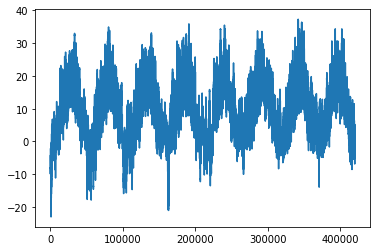

In [4]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)
plt.show()

다음은 기간을 좁혀서 처음 10일간 온도 데이터를 나타낸 그래프, 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있음

#### 코드 10-4 처음 10일간의 온도를 그래프로 그리기

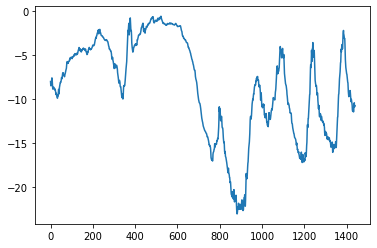

In [5]:
plt.plot(range(1440), temperature[:1440])
plt.show()

__cf) 항상 데이터에서 주기성을 찾아라 __

여러 시간 범위에 걸친 주기성은 시계열 데이터에서 중요하고 매우 일반적인 성질 <br>
일별주기/연간주기 등 데이터 탐색 시 이런 패턴을 차아라. <br><br>


연간데이터 주기성은 안정적이지만, 하루하루 데이터를 삺보면 온도 변화는 매우 불안정하다. <br>
모든 예제에서 처음 50%의 데이터를 훈련에 사용하고 다음 25%를 검증, 마지막 25%를 테스트에 사용, 시계열 데이터를 다룰 때 검증 데이터와 테스트 데이터가 훈련 데이터보다 최신이어야 한다. 시계열 데이터를 다룰 때 검증 데이터와 테스트 데이터가 훈련 데이터보다 최신이어야 한다. 미래에서 과거를 예측하는 것이 아니라 과거를 바탕으로 미래를 예측하기 때문이다. <br>

#### 코드 10-5 각 분할에 사용할 샘플 개수 계산하기

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples -num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


#### 10.2.1 데이터 준비
한 시간에 한번씩 샘플링된 5일간의 데이터가 주어졌을 때 24시간 뒤의 온도를 예측할 수 있을까? 데이터에 있는 시계열은 스케일이 각기 다름. 각 시계열을 독립적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠음.

#### 코드 10-6 데이터 정규화

In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[num_train_samples].std(axis=0)
raw_data /= std 

데이터에 중복이 많으므로 모든 샘플을 메모리에 적재하면 낭비가 됨. <br><br>

__cf) timeseries_daaset_from_array() 이해하기__ <br>

timeseries_dataset_from_array() 함수가 원본 시계열에서 추출한 윈도우를 제공, 파이썬 제너레이터를 만들어 처리할 수 있지만 케라스에 내장된 데이터셋 유틸리티(timeseries_dataset_from_array())가 있음

In [12]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)  # 0에서 9까지 정렬된 정수 배열을 만듦
dummy_dataset = keras.utils.timeseries_dataset_from_array(
            data = int_sequence[:-3],
            targets = int_sequence[3:],
            sequence_length=3,
            batch_size=2
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


다음과 같음 매개변수 값을 사용

- sampling_rate = 6: 시간당 하나의 데이터 포인트가 샘플링된다. 즉, 6개의 데이터 포인트 중 하나만 사용 <br>
- sequence_length = 120: 이전 5일간(120시간) 데이터를 사용한다 <br>
- delay = sampling_rate*(sequence_length+24-1): 시퀀스의 타깃은 시퀀스 끝에서 24시간 후의 온도 <br>

훈련 데이터셋을 만들 때 처음 50%의 데이터만 사용하기 위해 start_index=0과 end_index=num_train_samples로 지정, 검증 데이터셋의 경우 그 다음 25%를 사용하기 위해 start_index = num_train_samples와 end_index=num_train_samples+num_val_samples로 지정. 마지막으로 테스트 데이터셋의 경우 남은 샘플을 사용하기 위해 start_index=num_train_samples + num_val+samples로 지정

#### 코드 10-7 훈련, 검증, 테스트 데이터셋 만들기

In [13]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate*(sequence_length+24-1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples+num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index = num_train_samples+num_val_samples
)

각 데이터셋은 (samples, targets) 크기의 튜플을 반환함. 

#### 코드 10-8 훈련 데이터셋의 배치 크기 확인하기

In [14]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


#### 10.2.2 상식 수준의 기준점
블랙박스 같은 딥러닝 모델을 사용하여 온도예측 문제를 풀기 전에 간단한 상식 수준의 해법을 시도, 이는 정상적인 문제인지 확인하기 위한 용도이며 고수준 머신러닝 모델이라면 뛰어넘어야 할 기준점이 된다. 

np.mean(np.abs(preds-targets))

#### 코드 10-9 상식 수준 모델의 MAE 계산하기

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        # 온도 특성은 칼럼 인덱스 1에 있음, 따라서 samples[:, -1, 1]이 입력 시퀀스에 있는 마지막 온도 측정값임. 
        # 특성을 정규화했기 때문에 온도를 섭씨로 바꾸려면 표준 편차를 곱하고 평균을 더해야 한다. 
        total_abs_err += np.sum(np.abs(preds-targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

아주 나쁘지는 않지만 이런 규칙을 기반으로 날씨 에보 서비스를 시작하지는 않을 것임.

#### 10.2.3 기본적인 머신 러닝 모델 시도해 보기
2개의 Dense층을 통과시키는 완전 연결 네트워크를 보여준다. 마지막 Dense층에 활성화 함수를 두지 않았다. 손실 함수로 MAE 대신 펴윤제곱 오차MSE를 사용함. MSE는 원점에서 미분 가능하기 때문에 경사 하강법에 잘 맞는다. compile() 메서드에 모니터링할 지표로 MAE를 추가한다.

#### 코드 10-10 밀집 연결 모델 훈련하고 평가하기

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",  # 콜백을 사용해서 최상의 모델을 저장한다.
                                   save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data = val_dataset, callbacks=callbacks)
# 최상의 모델을 다시 로드하고 테스트 데이터에서 평가함
model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")  

Epoch 1/10
819/819 [==============================] - 51s 47ms/step - loss: 17.3656 - mae: 3.1975 - val_loss: 14.7148 - val_mae: 3.0482
Epoch 2/10
819/819 [==============================] - 38s 46ms/step - loss: 10.0034 - mae: 2.4926 - val_loss: 11.0304 - val_mae: 2.6172
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 8.9028 - mae: 2.3506 - val_loss: 11.0465 - val_mae: 2.6170
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 8.3359 - mae: 2.2747 - val_loss: 10.9839 - val_mae: 2.6165
Epoch 5/10
819/819 [==============================] - 38s 46ms/step - loss: 7.9133 - mae: 2.2142 - val_loss: 11.8518 - val_mae: 2.7232
Epoch 6/10
819/819 [==============================] - 37s 45ms/step - loss: 7.6171 - mae: 2.1732 - val_loss: 11.1697 - val_mae: 2.6455
Epoch 7/10
819/819 [==============================] - 38s 46ms/step - loss: 7.3711 - mae: 2.1379 - val_loss: 12.5372 - val_mae: 2.8098
Epoch 8/10
819/819 [==============================] -

#### 코드 10-11 결과 그래프 그리기

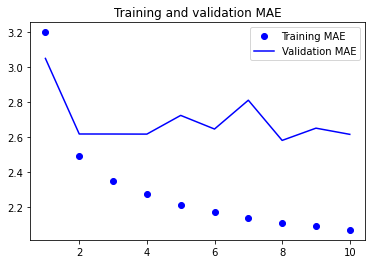

In [20]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

일부 검증 손실은 학습을 사용하지 않은 기준점에 가깝지만 안정적이지 못하다, 간단하고 괜찮은 성능을 내는 모델이 데이터와 타깃을 매핑할 수 있다면 왜 훈련한 모델은 이를 찾지 못하고 성능이 낮을까?
즉 가설 공간은 우리가 매개변수로 설정한 2개의 층을 가진 네트워크의 모든 가능한 가중치 조합이다. 기술적으로 가설 공간에 좋은 솔루션이 존대한다는 것이 경사 하강법으로 찾을 수 있다는 의미는 아니기 때문.
이게 바로 머신러닝이 가진 심각한 제약 사항, 특정한 종류의 간단한 모델을 찾도록 학습 알고리즘을 하드코딩하지 않았다면, 종종 간단한 문제를 위한 간략한 해결책을 찾지 못할 수 있다.

#### 10.2.4 1D 합성곱 모델 시도해 보기
Conv1D 층은 1D 윈도우를 사용하여 입력 시퀀스를 슬라이딩한다. 

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks=[
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                   save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                     epochs=10,
                     validation_data = val_dataset,
                     callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE:{model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 35s 42ms/step - loss: 23.9635 - mae: 3.8136 - val_loss: 16.9089 - val_mae: 3.2153
Epoch 2/10
819/819 [==============================] - 36s 44ms/step - loss: 16.1727 - mae: 3.1881 - val_loss: 17.2833 - val_mae: 3.3418
Epoch 3/10
819/819 [==============================] - 35s 42ms/step - loss: 14.6937 - mae: 3.0325 - val_loss: 15.3697 - val_mae: 3.1323
Epoch 4/10
819/819 [==============================] - 36s 44ms/step - loss: 13.6871 - mae: 2.9234 - val_loss: 15.6599 - val_mae: 3.1683
Epoch 5/10
819/819 [==============================] - 36s 43ms/step - loss: 13.0536 - mae: 2.8533 - val_loss: 18.0023 - val_mae: 3.4032
Epoch 6/10
819/819 [==============================] - 35s 43ms/step - loss: 12.5965 - mae: 2.8023 - val_loss: 16.7322 - val_mae: 3.2392
Epoch 7/10
819/819 [==============================] - 36s 43ms/step - loss: 12.1640 - mae: 2.7535 - val_loss: 20.5437 - val_mae: 3.6262
Epoch 8/10
819/819 [============================

이 모델은 밀집 연결 모델보다 더 성능이 나쁘다. 약 2.9 정도의 검증 MAE를 달성하여 상식 수준의 모델과 차이가 크다. 문제는 <br>
1) 날씨 데이터는 평행 이동 불변성 가정을 많이 따르지 않는다. <br>
2) 이 데이터는 순서가 많이 중요하다. <br>

#### 10.2.5 첫 번째 순환 신경망
밀집 연결 모델이나 합성곱 모델이 잘 작동하지 않았지만 그렇다고 이 문제에 머신 러닝이 적합하지 않다는 뜻은 아니다, 밀집 연결 모델은 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버렸다. 인과 관계와 순서가 의미 있는 시퀀스 데이터를 그대로 사용해 보겠다. 

#### 코드 10-12 간단한 LSTM 기반 모델

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                   save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
         epochs=10,
         validation_data = val_dataset,
         callbacks = callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE:{model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 43s 45ms/step - loss: 47.0193 - mae: 4.9544 - val_loss: 12.5852 - val_mae: 2.6784
Epoch 2/10
819/819 [==============================] - 36s 43ms/step - loss: 11.2002 - mae: 2.5765 - val_loss: 9.5734 - val_mae: 2.4007
Epoch 3/10
819/819 [==============================] - 36s 43ms/step - loss: 9.6620 - mae: 2.4273 - val_loss: 9.7643 - val_mae: 2.4083
Epoch 4/10
819/819 [==============================] - 35s 43ms/step - loss: 9.2204 - mae: 2.3741 - val_loss: 9.7993 - val_mae: 2.4109
Epoch 5/10
819/819 [==============================] - 36s 43ms/step - loss: 8.8361 - mae: 2.3222 - val_loss: 9.9330 - val_mae: 2.4249
Epoch 6/10
819/819 [==============================] - 36s 43ms/step - loss: 8.5672 - mae: 2.2867 - val_loss: 9.8410 - val_mae: 2.4267
Epoch 7/10
819/819 [==============================] - 36s 43ms/step - loss: 8.3702 - mae: 2.2611 - val_loss: 9.7333 - val_mae: 2.4089
Epoch 8/10
819/819 [==============================] - 35s 4

아까보다 성능이 훨씬 좋아졌다. LSTM 모델이 밀집 연결 모델이나 컨브넷보다 뛰어난 성능을 내는 이유는 무엇일까? 

### 10.3 순환 신경망 이해하기
지금까지 본 모든 신경망의 특징은 메모리가 없다는 것 <br>
예를 들어 밀집 연결 모델에서 보았듯이 5일치 데이터를 펼쳐서 하나의 큰 벡터로 만들어 처리했다. 이런 네트워크를 feedforward network라고 한다. <br>
생물학적 지능은 정보 처리를 위한 내부 모델을 유지하면서 짐진적으로 정보를 처리한다 <br>
순환 신경망(Recurrent Neural Network, RNN)은 같은 원리를 적용한 것, 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 상태state에 저장한다. 

#### 코드 10-13 의사 코드로 표현한 RNN

In [ ]:
state_t = 0  # 타임스텝 t의 상태
for input_t in input_sequence:    # 시퀀스의 원소를 반복한다.
    output_t = f(input_t, state_t)
    state_t = output_t  # 출력은 다음 반복을 위한 상태가 된다. 

f함수는 입력과 상태를 출력으로 변환, 이를 2개의 행렬W와 U그리고 편향 벡터를 사용하는 변환으로 바꿀 수 있다.

#### 코드 10-14 좀 더 자세한 의사 코드로 표현한 RNN

In [ ]:
state_t=0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t)+dot(U, state_t)+b)
    state_t = output_t

완전하게 이해하기 위해 간단한 RNN의 정방향 계산을 넘파이로 구현

#### 코드 10-15 넘파이로 구현한 간단한 RNN

In [ ]:
import numpy as np

timesteps = 100  # 입력 시퀀스에 있는 타임스텝의 수
input_features = 32  # 입력 특성의 차원
output_features = 64 # 출력 특성의 차원
inputs = np.random.random((timesteps, input_features))   # 입력 데이터: 예지를 위한 랜덤한 잡음
state_t = np.zeros((output_features, input_features))
# 랜덤한 가중치 행렬을 만듦
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []
for input_t in inputs:
    # 입력과 현재 상태 (이전 출력)를 연결하여 현재 출력을 얻는다. 
    # tanh함수를 사용해서 비선형성을 추가 (다른 활성화 함수도 사용할 수 있음)
    output_t = np.tanh(np.dot(W, input_t)+ np.dot(U, state_t)+b)
    successive_outputs.append(output_t)  # 출력을 리스트에 저장
    state_t = output_t  # 다음 타임스텝을 위해 네트워크의 상태를 업데이트한다
final_output_sequence = np.stack(successive_outputs, axis=0)   # 최종 출력은 (timesteps, output_features) 크기의 rank-2 tensor이다. 

위 예에서 RNN은 반복할 때 이전에 계산한 정보를 재사용하는 for loop에 지나지 않다. RNN은 step 함수에 의해 특화된다. <br>
output_t = np.tanh(np.dot(W, input_t)+np.dot(U, state_t)+b) <br>

__cf) Note__
이 예에서 최종 출력은 (timesteps, output_features)크기의 rank-2 tensor. 각 타임스텝은 시간 t에서의 출력을 나타내미 출력 텐서의 각 타임스텝 t에는 입력 시퀀스에 있는 타임스텝 0에서 t까지 전체 과거에 대한 정보를 담고 있다. 이런 이유때문에 많은 경우 전체 출력 시퀀스가 필요하지 않다. 전체 시퀀스에 대한 정보를 이미 담고 있으므로 마지막 출력(루프의 마지막 output_t)만 있으면 된다. <br><br>


#### 10.3.1 케라스의 순환 층
SimpleRNN이 한가지 다른점은 넘파이 예제처럼 하나의 시퀀스가 아니라 케라스의 다른 층과 마찬가지로 시퀀스의 배치를 처리한다는 것. 즉, (timesteps, input_features)크기가 아니라 (batch_size, timesteps, input_features) 크기의 입력을 받는다. 시작할 떄 Input() 함수의 shape 매개변수에 timesteps 항목을 None으로 지정할 수 있다. 

#### 코드 10-16 어떤 길이의 시퀀스도 처리할 수 있는 RNN층

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model.summary()가 출력 길이 정보를 제공할 수 있고 일부 성능 최적화를 활용할 수 있다. <br>
케라스에 있는 모든 순환 층(Simple RNN, LSTM. GRU)는 2가지 모드로 실행 할 수 있다. <br>
1) ((batch_size, timesteps, output_features))크기의 rank-3 tensor를 반환하거나 <br>
2) 입력 시퀀스의 마지막 출력 (batch_size, output_features) 크기의 rank-2 tensor만 반환 할 수 있다. <br>

#### 코드 10-17 마지막 출력 스텝만 반환하는 RNN층

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)  # return_sequences=False가 기본값
print(outputs.shape)

In [5]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data =int_sequence,
    targets = int_sequence[4:],
    sequence_length = 4,
    batch_size=2)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))
        
        
print(dummy_dataset)

[0, 1, 2, 3] 4
[1, 2, 3, 4] 5
[2, 3, 4, 5] 6
[3, 4, 5, 6] 7
[4, 5, 6, 7] 8
[5, 6, 7, 8] 9
<BatchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>
